In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import datetime as dt

# グラフ化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 設定
import warnings
warnings.filterwarnings("ignore")

# 予測
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

EDA:データの可視化

In [2]:
# データの読み込み
train = pd.read_csv('newly_confirmed_cases_daily.csv')
train.head()

,date,cases
0,2020/1/16,1
1,2020/1/17,0
2,2020/1/18,0
3,2020/1/19,0
4,2020/1/20,0


In [3]:
print(train.dtypes)

date     object
cases     int64
dtype: object


In [4]:
# データの型変換
train["date"] = pd.to_datetime(train["date"])
print(train.dtypes)

date     datetime64[ns]
cases             int64
dtype: object


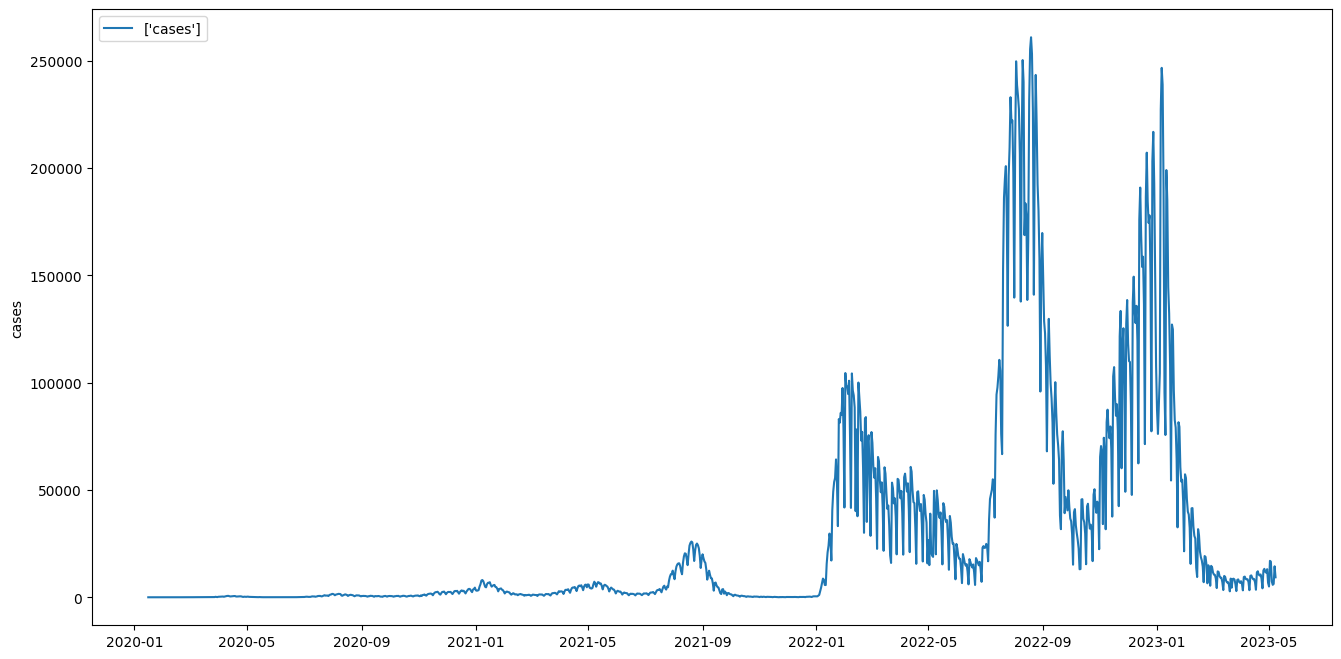

In [5]:
plt.figure(figsize=(16, 8))
plt.ylabel("cases")
plt.plot(train["date"], train["cases"], label=["cases"])
plt.legend(loc='upper left')

plt.show()

In [6]:
data = train[(train['date'] >= dt.datetime(2022,1,1)) & (train['date'] < dt.datetime(2023,1,1))]
data.reset_index(inplace=True)

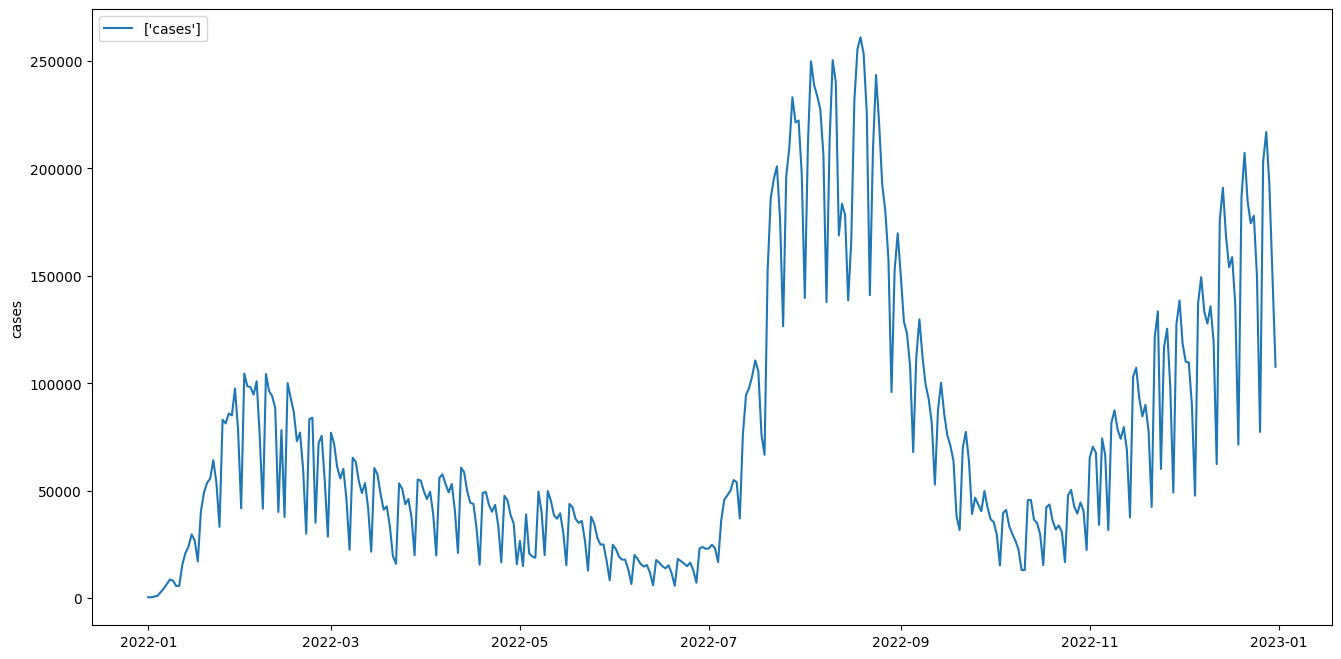

In [7]:
plt.figure(figsize=(16, 8))
plt.ylabel("cases")
plt.plot(data["date"], data["cases"], label=["cases"])
plt.legend(loc='upper left')

plt.show()

移動平均グラフ

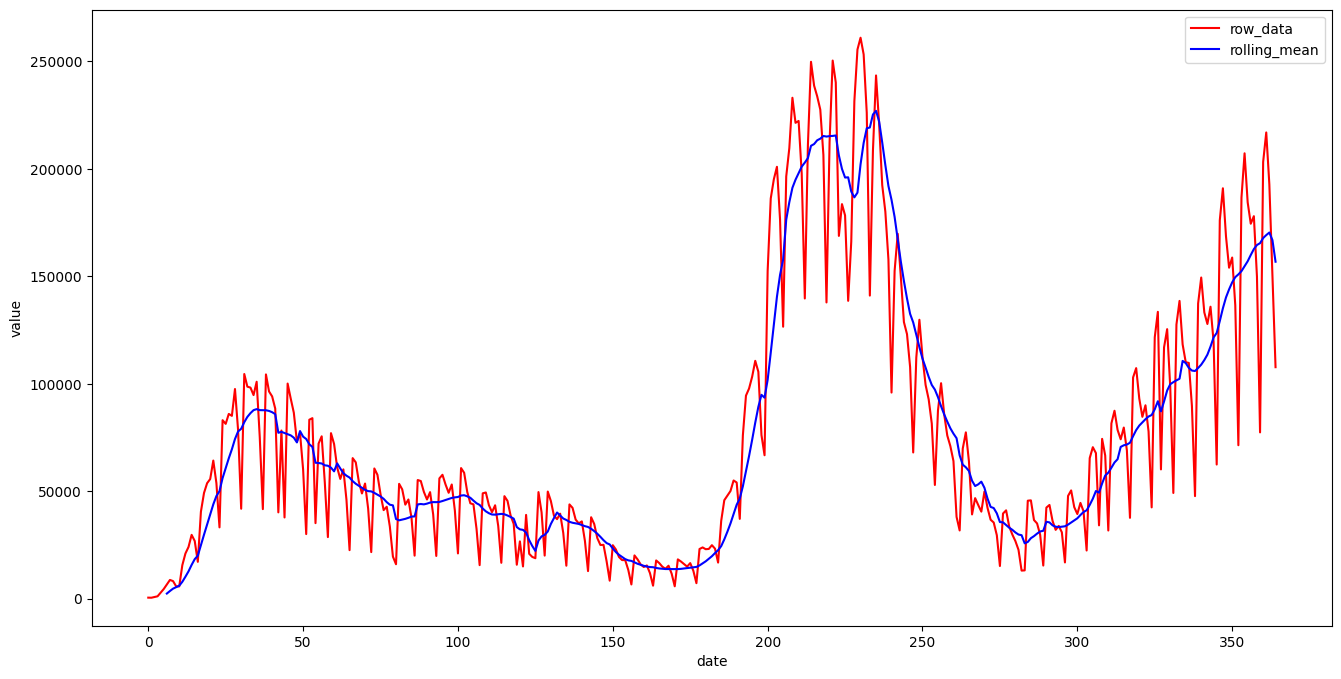

In [8]:
rolling_mean = data['cases'].rolling(window = 7).mean()
#可視化
plt.figure(figsize=(16, 8))
plt.plot(data['cases'], color ="red",label = 'row_data')
plt.plot(rolling_mean, color ="blue",label = 'rolling_mean')
plt.ylabel("value")
plt.xlabel("date")
plt.legend(loc = 'upper right')
plt.show()

ADF検定

結果：有意になったので階差をとらなくていい

In [9]:
# P値　および　Test StatisticとCritical Valueを比較して確認する

print('Results of Dickey-Fuller Examination:')
dftest = adfuller(data['cases'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
   dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Examination:
Test Statistic                  -3.064053
p-value                          0.029330
#Lags Used                      16.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


トレンドの有無を考慮したパラメータチューニング

In [10]:
# トレンドなし
print('--------トレンドなし--------')
print(sm.tsa.arma_order_select_ic(data['cases'], ic='aic', trend='n'))
# トレンドあり
print('--------トレンドあり--------')
print(sm.tsa.arma_order_select_ic(data['cases'], ic='aic', trend='c'))

--------トレンドなし--------


c:\Users\daisuke\anaconda3\envs\time_series_train\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':              0            1            2
0  9418.328129  9173.216668  9119.132756
1  8489.471279  8453.229161  8416.442341
2  8482.462060  8492.718723  8414.359879
3  8435.412169  8412.497773  8416.076191
4  8430.502130  8414.054481  8367.987824, 'aic_min_order': (4, 2)}
--------トレンドあり--------
{'aic':               0            1            2
0  10880.652584  8857.209081  8805.562108
1   8479.898926  8452.432195  8416.366322
2   8475.627046  8481.569567  8414.298094
3   8432.827261  8412.253811  8416.014456
4   8428.870062  8413.935225  8362.926461, 'aic_min_order': (4, 2)}


階差なし＆チューニング結果を用いてARIMAモデルを構築

In [11]:
# ARIMAモデルの作成とフィッティング
model = ARIMA(data["cases"], order=(4, 0, 2))
model_fit = model.fit()

In [12]:
# 10ステップ先のデータを予測
forecast = model_fit.forecast(steps=10)

# 予測結果の表示
print(forecast)

365    102542.585953
366     79205.591515
367    109071.757263
368    110505.098822
369     79340.479727
370     89785.383021
371    112833.866875
372     89527.132845
373     75916.049950
374    102879.857492
Name: predicted_mean, dtype: float64


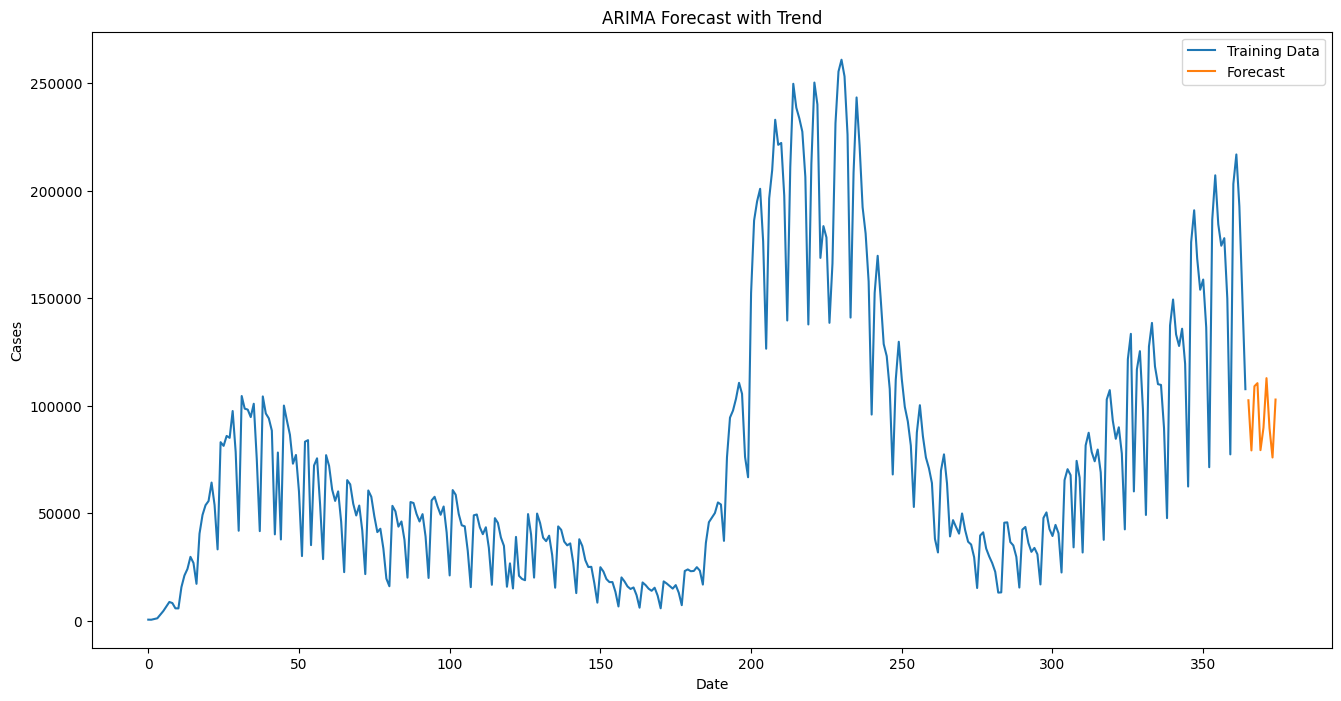

In [13]:
# 予測結果のインデックスを作成
forecast_index = range(len(data["cases"]), len(data["cases"]) + len(forecast))

# グラフのプロット
plt.figure(figsize=(16, 8))
plt.plot(data["cases"], label="Training Data")
plt.plot(forecast_index, forecast, label="Forecast")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("ARIMA Forecast with Trend")
plt.legend()
plt.show()